# Simple Bandit Reward

In [2]:
# reload notebook
%load_ext autoreload
%autoreload 2
import torch
from IPython.display import clear_output
import matplotlib
matplotlib.rc('font', size=16)
matplotlib.rc('lines', linewidth=2.5)
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import numpy as np
import tqdm
import torch.nn as nn
import torch.distributions as thdist
import torch.nn.functional as thfunc
from mpl_toolkits.axes_grid1 import make_axes_locatable
device = torch.device('cpu')
import sys 
sys.path.append("/scr/aliang80/changepoint_aug/online_rl_diffusion")
from diffusion_policy import MLPBandit, DiffusionBandit
from helpers import EMA

def barplot_color(x, y):
    import matplotlib as mpl
    cmap = mpl.cm.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, len(x)))
    plt.bar(x, y, color=colors)
    plt.xticks(x, labels=x)

def plt_save_fig_array(close=True, clear=True):
    fig = plt.gcf()
    fig.canvas.draw()
    res = np.array(fig.canvas.renderer.buffer_rgba())
    if close: plt.close()
    if clear: plt.clf()
    return res

def animate(clip, filename='animation.mp4', _return=True, fps=10, embed=False):
    # embed = True for Pycharm, otherwise False
    if isinstance(clip, dict):
        clip = clip['image']
    print(f'animating {filename}')
    if filename.endswith('.gif'):
        import imageio
        import matplotlib.image as mpimg
        imageio.mimsave(filename, clip)
        if _return:
            from IPython.display import display
            import ipywidgets as widgets
            return display(widgets.HTML(f'<img src="{filename}" width="750" align="center">'))
        else:
            return

    from moviepy.editor import ImageSequenceClip
    clip = ImageSequenceClip(clip, fps=fps)
    ftype = filename[-3:]
    if ftype == "mp4":
        clip.write_videofile(filename, fps=fps)
    elif ftype == "gif":
        clip.write_gif(filename, fps=fps)
    else:
        raise NotImplementedError(f"file type {ftype} not supported!")

    if _return:
        from IPython.display import Video
        return Video(filename, embed=embed, html_attributes="controls autoplay muted loop")

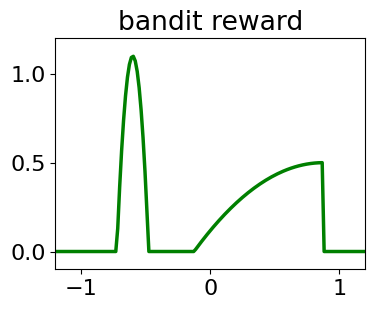

In [2]:
# feel free to try different reward functions
def reward(x):
    y1 = torch.clip(-18 * (2 * x + 1.2) ** 2 + 1.1, min=0)
    y2 = torch.clip(-0.125 * (2 * x - 1.75) ** 2 + 0.5, min=0)
    y2 = y2 * (x < 1.75 / 2).float()
    return y1 + y2

# def reward(x):
#     y1 = torch.clip(-18 * (2 * x + 1.2) ** 2 + 1.1, min=0)
#     y2 = torch.clip(-0.125 * (4 * x - 1.75) ** 2 + 0.5, min=0)
#     # y2 = y2 * (x < 1.75 / 4).float()
#     return y1 + y2

def plot_reward(x, y):
    plt.xlim(-1.2, 1.2); plt.ylim(-0.1, 1.2)
    plt.plot(x.reshape(-1).cpu().numpy(), y.reshape(-1).cpu().numpy(), color='green')

# visualize reward landscape
plt.figure(figsize=(4, 3))
plt.title("bandit reward")
x = torch.linspace(-1.5, 1.5, 200)
y = reward(x)
plot_reward(x, y)
plt.show()

# Gaussian Policy with learnable mean + std

In [26]:
class Std(nn.Module):
    
    def __init__(
            self, out_dim, mode="local", learn=True, 
            scale=1, log_std_min=-20, log_std_max=2, init_log_std=0
        ):
        super().__init__()
        self.out_dim      = out_dim
        self.mode         = mode
        self.learn        = learn
        self.log_std_min  = log_std_min
        self.log_std_max  = log_std_max
        self.init_log_std = init_log_std
        self.scale        = scale
        assert self.mode in ["global", "local"], "mode must be 'global' or 'local'"
        
        # decide whether to manage std
        self.manage_std   = (mode == "global")
        if not self.learn:
            # if not learning std, then it's global
            self.manage_std = True
        
        # manage std
        self.log_std = None
        if self.manage_std:
            self.log_std = nn.Parameter(
                self.init_log_std * \
                torch.ones((1, out_dim), dtype=torch.float32)
            )
            self.in_dim = 0
        else:
            self.in_dim = out_dim

    def extra_repr(self):
        repr_str = (
            f"mode={self.mode},\n"
            f"learn={self.learn},\n"
            f"log_std_min={self.log_std_min},\n"
            f"log_std_max={self.log_std_max},\n"
            f"init_log_std={self.init_log_std},\n"
            f"scale={self.scale}")
        if self.manage_std:
            repr_str += f",\nlog_std={self.log_std.tolist()}"
        return repr_str

    def forward(self, x):
        if self.manage_std:
            # use the global logstd
            assert self.log_std is not None
            logstd = self.log_std
        else:
            # take the input as logstd
            assert x.shape[-1] == self.out_dim
            logstd = x + self.init_log_std
        
        logstd = torch.clamp(logstd, min=self.log_std_min, max=self.log_std_max)
        
        std = torch.exp(logstd)
        if not self.learn:
            # detach std if not learning it
            std = std.detach()
        
        return std * self.scale
    
class TanhNormalHead(nn.Module):

    def __init__(self, out_dim, std_cfg=dict()):
        super().__init__()
        self.std = Std(out_dim, **std_cfg)
        self.out_dim = out_dim
        self.in_dim = self.out_dim + self.std.in_dim
    
    def forward(self, x):
        assert x.shape[-1] == self.in_dim
        mu = x[..., :self.out_dim]
        std = self.std(x[..., self.out_dim:])
        # sample and log_prob
        dist = thdist.Normal(loc=mu, scale=std)
        u = dist.rsample()
        a = torch.tanh(u)
        log_prob_a = dist.log_prob(u) - (2 * (np.log(2) - u - thfunc.softplus(-2 * u)))
        return dict(dist=dist, a=a, log_prob_a=log_prob_a)

class GaussianPolicy(nn.Module):
    def __init__(self, std_cfg=dict()):
        super().__init__()
        self.mu = nn.Parameter(torch.tensor([0.0]))
        self.std = nn.Parameter(torch.tensor([1.0]))
        self.head = TanhNormalHead(1, std_cfg)

    def forward(self, sample_size):
        x = torch.cat([self.mu, self.std])[None, :].repeat(sample_size, 1)
        return self.head(x)
    
pi_a_example = GaussianPolicy().to(device)
pi_a_example(5)

{'dist': Normal(loc: torch.Size([5, 1]), scale: torch.Size([5, 1])),
 'a': tensor([[0.7987],
         [0.4605],
         [0.9408],
         [0.9720],
         [0.7589]], device='cuda:0', grad_fn=<TanhBackward0>),
 'log_prob_a': tensor([[-0.9840],
         [-1.6974],
         [ 0.0392],
         [ 0.6722],
         [-1.1280]], device='cuda:0', grad_fn=<SubBackward0>)}

# Visualize gaussian policy

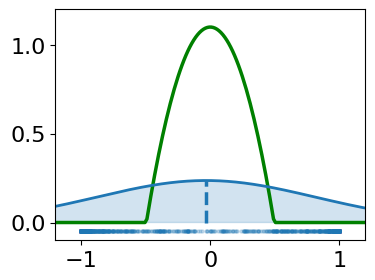

In [27]:
# visualize the distribution of actions
def dist_hist(actions, bins):
    x_freq = np.linspace(-2.5, 2.5, bins + 1)
    inds = np.digitize(actions, x_freq)
    freq = np.zeros_like(x_freq)
    unique, counts = np.unique(inds, return_counts=True)
    for i, count in zip(unique, counts):
        freq[i-1] = count
    freq = freq / freq.sum() * 2
    return x_freq + (x_freq[1] - x_freq[0]) / 2, freq * 2.4

@torch.no_grad()
def visualize_gaussian_policy(policy, batch_size=10000):
    policy_out = policy(batch_size)
    a = policy_out["a"]
    # when policy is gaussian, fit a gaussian to the distribution for better visualization
    mu, std = a.mean().cpu(), a.std().cpu()
    x = torch.linspace(-1.5, 1.5, 1000)
    # scale the pdf for better visualization
    pdf = torch.exp(-((x - mu) ** 2) / (2 * std ** 2)) / (std * np.sqrt(2 * np.pi))
    # pdf = pdf - (2 * (np.log(2) - x - thfunc.softplus(-2 * x)))  # the tanh transformed pdf
    # pdf[np.abs(x) > 1] = 0
    pdf = pdf / 2  # scale the pdf for better visualization
    plt.plot([mu, mu], [0, pdf.max()], color='C0', linestyle='--')  # plot mean
    plt.plot(x, pdf, color='C0', linewidth=2)
    # scatter action samples
    actions = a.cpu().numpy()
    plt.scatter(actions, np.zeros_like(actions) - 0.05, color='C0', s=5, alpha=0.2)
    plt.fill_between(x, pdf, color='C0', alpha=0.2)

plt.figure(figsize=(4, 3))
# visualize reward landscape
x = torch.linspace(-1.5, 1.5, 200)
y = reward(x)
plot_reward(x, y)
# visualize the initialized policy
visualize_gaussian_policy(GaussianPolicy(), batch_size=1000)
plt.show()

# Policy gradient for gaussian policy

In [3]:
def update_gaussian_reinforce(reward, policy, optimizer, reward_weight, ent_a, batch_size):
    optimizer.zero_grad()
    policy_out = policy(sample_size=batch_size)
    a, log_prob_a = policy_out["a"], policy_out["log_prob_a"]
    r = reward(a)
    r_max_ent = reward_weight * reward(a) - ent_a * log_prob_a
    adv = (r_max_ent - r_max_ent.mean()).detach()
    policy_loss = -(log_prob_a * adv).mean()
    policy_loss.backward()
    optimizer.step()

    return dict(reward=r.mean().item())

# Train Gaussian policy on bandit problem, converges to local optimum

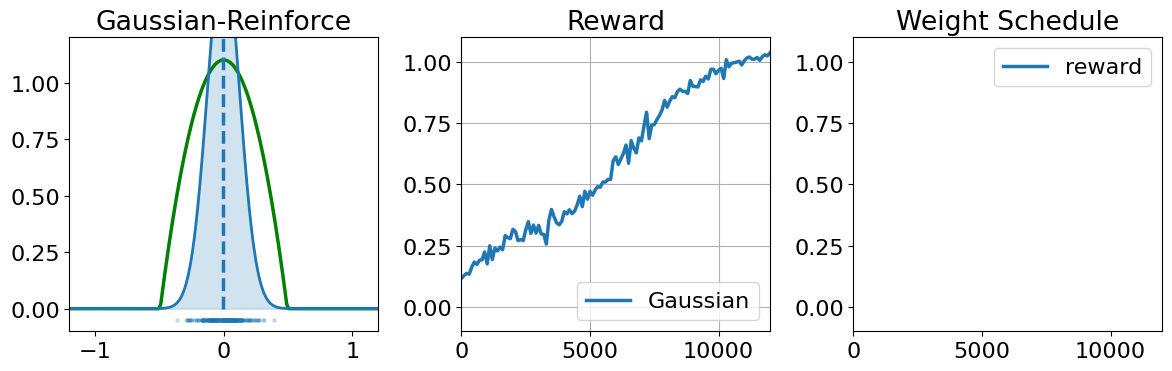

100%|██████████| 12001/12001 [00:57<00:00, 209.05it/s]


In [29]:
gaussian_policy = GaussianPolicy().to(device)
gaussian_opt = torch.optim.Adam(gaussian_policy.parameters(), lr=1e-3)

# decay the cross entropy and action entropy weight in reward
decay_rate = 0.9995
reward_weight, info_weight, ent_z, ent_a = 0.1, 0.8, 0.2, 0.2
batch_size = 256

# record the reward
rewards_gaussian = []
video_imgs = []
reward_weights = []
info_weights = []

visualize_every = 100
T = 12000

for t in tqdm.trange(T + 1):
    # to compare, optimize gaussian policy with reinforce
    gaussian_update_info = \
        update_gaussian_reinforce(
            reward, gaussian_policy, gaussian_opt, 
            reward_weight, ent_a, batch_size)
    
    ent_a = ent_a * decay_rate 

    # visualize
    if t % visualize_every == 0:
        clear_output(wait=True)
        total_plots = 3
        fig_width = 4
        plt.figure(figsize=(total_plots * fig_width, fig_width))
        rewards_gaussian.append(gaussian_update_info["reward"])

        # visualize Gaussian-Reinforce
        plt.subplot(1, total_plots, 1)
        plt.title("Gaussian-Reinforce")
        x = torch.linspace(-1.5, 1.5, 200)
        y = reward(x)
        plot_reward(x, y)
        visualize_gaussian_policy(gaussian_policy, batch_size=256)

        # visualize reward
        plt.subplot(1, total_plots, 2)
        plt.xlim(0, T); plt.ylim(-0.1, 1.1)
        plt.title("Reward")
        plt.plot(np.arange(len(rewards_gaussian)) * visualize_every, rewards_gaussian, color="C0", label="Gaussian")
        plt.grid()
        plt.legend(loc="lower right")

        # visualize weights
        plt.subplot(1, total_plots, 3)
        plt.xlim(0, T); plt.ylim(-0.1, 1.1)
        plt.title("Weight Schedule")
        plt.plot(reward_weights, label="reward")
        # plt.plot(info_weights, label="info")
        plt.legend(loc="upper right")

        plt.tight_layout()
        video_imgs.append(plt_save_fig_array(close=False, clear=False))
        plt.show()

# Visualize Diffusion Policy samples

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


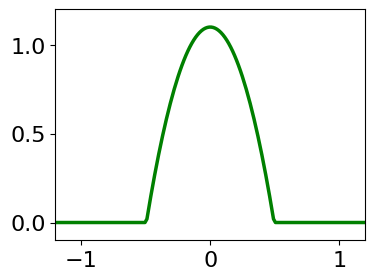

In [12]:
# visualize the distribution of actions
def dist_hist(actions, bins):
    x_freq = np.linspace(-2.5, 2.5, bins + 1)
    inds = np.digitize(actions, x_freq)
    freq = np.zeros_like(x_freq)
    unique, counts = np.unique(inds, return_counts=True)
    for i, count in zip(unique, counts):
        freq[i-1] = count
    freq = freq / freq.sum() * 2
    return x_freq + (x_freq[1] - x_freq[0]) / 2, freq * 2.4

@torch.no_grad()
def visualize_diffusion_policy(policy, batch_size=10000, pdf_scale=1):
    # print(torch.randn(batch_size, 1).float().to(device))
    actions = policy(batch_size).cpu().numpy()
    # z = policy_out["z"].argmax(dim=-1).cpu().numpy()
    # actions = a.reshape(-1).cpu().numpy()
    # print(actions.shape)
    print(actions.min(), actions.max())
    plt.scatter(actions, np.zeros_like(actions) - 0.05, s=5, alpha=0.2)
    # plt.colorbar()
    plt.clim(actions.min(), actions.max())
    x_freq, freq = dist_hist(actions, bins=50)
    X_Y_Spline = make_interp_spline(x_freq, freq)
    X_ = np.linspace(x_freq.min(), x_freq.max(), 1000)
    Y_ = np.clip(X_Y_Spline(X_), a_min=0, a_max=None)
    # spline interpolates out of the action bound, it looks confusing
    Y_[np.abs(X_) > 1] = 0
    Y_ *= pdf_scale
    plt.plot(X_, Y_, color='C3', linewidth=2)
    plt.fill_between(X_, Y_, color='C3', alpha=0.2)

plt.figure(figsize=(4, 3))
# visualize reward landscape
x = torch.linspace(-1.5, 1.5, 200)
y = reward(x)
plot_reward(x, y)
# visualize the initialized policy
device = torch.device('cuda')
model = MLPBandit(action_dim=1, device=device)
diffusion_policy = DiffusionBandit(
    action_dim = 1,
    model = model,
    max_action = 1,
    beta_schedule='linear',
    n_timesteps=100
).to(device)
visualize_diffusion_policy(diffusion_policy, batch_size=1000)
plt.show()

# Policy Gradients with Diffusion Policy

In [35]:
def update_diffusion_reinforce(reward, policy, optimizer, reward_weight, batch_size, alpha, beta, ent_a):
    optimizer.zero_grad()
    action = policy.sample(batch_size=batch_size).float()
    ddpm_loss = policy.loss(action.detach())
    r = reward(action.detach())
    r_max_ent = reward_weight * r - ent_a * ddpm_loss
    # adv = (r_max_ent - r_z.mean()).detach()
    # r = reward(action) * reward_weight
    # adv = (r - r.mean()).detach()
    # print(ddpm_loss.min(), ddpm_loss.max(), r.min(), r.max(), ddpm_loss.shape, r_max_ent.shape)
    policy_loss = -(ddpm_loss * r_max_ent).mean()
    # policy_loss = alpha * ddpm_loss.float().mean() - beta * (ddpm_loss.float() * r).mean()
    policy_loss.backward()
    # gradient clipping
    torch.nn.utils.clip_grad_norm_(policy.parameters(), 1.)
    optimizer.step()
    return dict(reward=r.mean().item(), ddpm_loss=ddpm_loss.mean().item(), policy_loss=policy_loss.item())

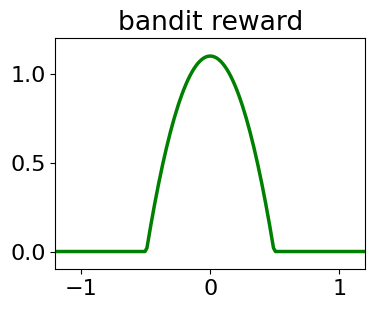

In [31]:
# feel free to try different reward functions
def reward(x):
    y1 = torch.clip(-18 * (0.5 * x) ** 2 + 1.1, min=0)
    # y2 = torch.clip(-0.125 * (2 * x - 1.75) ** 2 + 0.5, min=0)
    # y2 = y2 * (x < 1.75 / 2).float()
    return y1

# def reward(x):
#     y1 = torch.clip(-18 * (2 * x + 1.2) ** 2 + 1.1, min=0)
#     y2 = torch.clip(-0.125 * (4 * x - 1.75) ** 2 + 0.5, min=0)
#     # y2 = y2 * (x < 1.75 / 4).float()
#     return y1 + y2

def plot_reward(x, y):
    plt.xlim(-1.2, 1.2); plt.ylim(-0.1, 1.2)
    plt.plot(x.reshape(-1).cpu().numpy(), y.reshape(-1).cpu().numpy(), color='green')

# visualize reward landscape
plt.figure(figsize=(4, 3))
plt.title("bandit reward")
x = torch.linspace(-1.5, 1.5, 200)
y = reward(x)
plot_reward(x, y)
plt.show()

In [36]:
device = torch.device('cuda:1')
model = MLPBandit(action_dim=1, device=device)
diffusion_policy = DiffusionBandit(
    action_dim = 1,
    model = model,
    max_action = 1,
    beta_schedule='linear',
    n_timesteps=100,
    loss_type="l2"
).to(device)
diffusion_opt = torch.optim.Adam(diffusion_policy.parameters(), lr=3e-4)
ema = EMA(0.9)
ema.register(diffusion_policy)
action = diffusion_policy.sample(batch_size=batch_size).float()

In [33]:
model

MLPBandit(
  (time_mlp): Sequential(
    (0): SinusoidalPosEmb()
    (1): Linear(in_features=16, out_features=32, bias=True)
    (2): Mish()
    (3): Linear(in_features=32, out_features=16, bias=True)
  )
  (mid_layer): Sequential(
    (0): Linear(in_features=17, out_features=64, bias=True)
    (1): Mish()
  )
  (final_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [34]:
# decay the cross entropy and action entropy weight in reward
decay_rate = 0.9995
reward_weight, ent_a = 0.1, 0.2
batch_size = 256

# record the reward
rewards_gaussian = []
video_imgs = []
reward_weights = []
info_weights = []
ddpm_loss = []
policy_loss = []

visualize_every = 100
T = 10000
alphas = np.linspace(1, 0, T)
betas = np.linspace(0, 1, T)
ent_a_terms = []

for t in tqdm.trange(T + 1):

    alpha = alphas[t]
    beta = betas[t]

    # to compare, optimize gaussian policy with reinforce
    diffusion_update_info = \
        update_diffusion_reinforce(
            reward, diffusion_policy, diffusion_opt, reward_weight, batch_size, alpha, beta, ent_a)
    ema.update(diffusion_policy)
    ent_a = ent_a * decay_rate 
    
    # visualize
    if t % visualize_every == 0:
        clear_output(wait=True)
        total_plots = 4
        fig_width = 4
        plt.figure(figsize=(total_plots * fig_width, fig_width))
        rewards_gaussian.append(diffusion_update_info["reward"])
        ddpm_loss.append(diffusion_update_info["ddpm_loss"])
        policy_loss.append(diffusion_update_info["policy_loss"])
        print(diffusion_update_info["reward"], diffusion_update_info["ddpm_loss"], diffusion_update_info["policy_loss"])

        # visualize Gaussian-Reinforce
        plt.subplot(1, total_plots, 1)
        plt.title("Diffusion")
        x = torch.linspace(-1.5, 1.5, 200)
        y = reward(x)
        plot_reward(x, y)
        visualize_diffusion_policy(diffusion_policy, batch_size=256)

        # visualize reward
        plt.subplot(1, total_plots, 2)
        plt.xlim(0, T); plt.ylim(-0.1, 1.1)
        plt.title("Reward")
        plt.plot(np.arange(len(rewards_gaussian)) * visualize_every, rewards_gaussian, color="C0", label="Diffusion")
        plt.grid()
        plt.legend(loc="lower right")

        # visualize ddpm loss
        plt.subplot(1, total_plots, 3)
        plt.xlim(0, T); plt.ylim(-0.1, 1.5)
        plt.title("DDPM Loss")
        plt.plot(np.arange(len(ddpm_loss)) * visualize_every, ddpm_loss, label="ddpm_loss")
        plt.grid()
        plt.legend(loc="upper right")

        # visualize policy loss
        plt.subplot(1, total_plots, 4)
        plt.xlim(0, T); plt.ylim(-0.1, 0.5)
        plt.title("Policy Loss")
        plt.plot(np.arange(len(policy_loss)) * visualize_every, policy_loss, label="policy_loss")
        plt.grid()
        plt.legend(loc="upper right")

        plt.tight_layout()
        video_imgs.append(plt_save_fig_array(close=False, clear=False))
        plt.show()

0.0 16.448421478271484 -0.0
-0.9999999999999991 -0.9999999999999991


  5%|▍         | 500/10001 [00:34<10:47, 14.67it/s]


KeyboardInterrupt: 

In [ ]:
len(video_imgs)

50

In [ ]:
animate(video_imgs, filename="diffusion_training.gif", fps=5)

animating tiny_rpg.gif


HTML(value='<img src="tiny_rpg.gif" width="750" align="center">')

# Running BC on Metaworld data with DDPM loss

In [237]:
import pickle 
from diffusion_rl import Diffusion, MLP
with open('/scr/aliang80/changepoint_aug/diffusion/metaworld-assembly-v2_25_noise_0.pkl', 'rb') as f:
    data = pickle.load(f)

In [240]:
device = torch.device('cuda')
model = MLP(state_dim=39, action_dim=4, device=device)
diffusion_policy = Diffusion(
    state_dim = 39,
    action_dim = 4,
    model = model,
    max_action = 1,
    beta_schedule='linear',
    n_timesteps=100
).to(device)
lr = 3e-4
actor_optimizer = torch.optim.Adam(diffusion_policy.parameters(), lr=lr)

print("num of trajectories: ", len(data))
obs = [traj["obs"][:-1] for traj in data]
obs = np.concatenate(obs, axis=0)
obs = torch.from_numpy(obs).float().to(device)
# obs = torch.cat(torch.from_numpy(obs), dim=0).to(device)
acts = [traj["acts"] for traj in data]
# acts = torch.cat(acts, dim=0).to(device)
acts = np.concatenate(acts, axis=0)
acts = torch.from_numpy(acts).float().to(device)
print(obs.shape, acts.shape)

dataset = torch.utils.data.TensorDataset(obs.float(), acts.float())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

iterations = 5000 
metric = {'bc_loss': [], 'ql_loss': [], 'actor_loss': [], 'critic_loss': []}
for iter in range(iterations):
    # Sample replay buffer / batch
    avg_loss = 0
    for state, action in dataloader:
        state = state.float()
        action = action.float()
    # state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

        loss = diffusion_policy.loss(action, state)

        actor_optimizer.zero_grad()
        loss.backward()
        actor_optimizer.step()

        metric['actor_loss'].append(0.)
        metric['bc_loss'].append(loss.item())
        metric['ql_loss'].append(0.)
        metric['critic_loss'].append(0.)
        avg_loss += loss.item()
    avg_loss /= len(dataloader)

    if iter % 100 == 0:
        print(f"iter: {iter}, loss: {loss.item()}, avg_loss: {avg_loss}")

num of trajectories:  25
torch.Size([5000, 39]) torch.Size([5000, 4])
iter: 0, loss: 0.3427061438560486, avg_loss: 0.48674154074131687
iter: 100, loss: 0.05574493110179901, avg_loss: 0.04317548654124707
iter: 200, loss: 0.041806116700172424, avg_loss: 0.02649000150894251
iter: 300, loss: 0.0013530767755582929, avg_loss: 0.01660964124735822
iter: 400, loss: 0.058260947465896606, avg_loss: 0.01618776069600371
iter: 500, loss: 0.0076527064666152, avg_loss: 0.013311128300036999
iter: 600, loss: 0.0005778223276138306, avg_loss: 0.01074217752954345
iter: 700, loss: 0.001564266043715179, avg_loss: 0.014098955750099937
iter: 800, loss: 0.04597003012895584, avg_loss: 0.009648753727986655
iter: 900, loss: 0.0028250510804355145, avg_loss: 0.00728674361606046
iter: 1000, loss: 0.0012369006872177124, avg_loss: 0.008860195294329071
iter: 1100, loss: 0.003608555067330599, avg_loss: 0.014489303233950764
iter: 1200, loss: 0.0009959619492292404, avg_loss: 0.008008841276345657
iter: 1300, loss: 0.0007209

In [241]:
import tqdm
import sys 
sys.path.append("/scr/aliang80/changepoint_aug")
from env_utils import create_single_env

def sample_action(policy, state):
    state = torch.FloatTensor(state.reshape(1, -1)).to(device)
    with torch.no_grad():
        action = policy.sample(state)
    return action.cpu().data.numpy().flatten()

env_name = "metaworld-assembly-v2"
seed = 0
eval_episodes = 10
scores = []
successes = []
for eval_num in tqdm.tqdm(range(eval_episodes)):
    eval_env = create_single_env(
        env_name,
        seed=eval_num,
        image_based=False,
        noise_std=0.0,
        freeze_rand_vec=True
    )
    traj_return = 0.
    (state, info), done = eval_env.reset(), False
    success = False
    num_steps = 0
    while not done and num_steps < 200:
        action = sample_action(diffusion_policy, np.array(state))
        state, reward, done, truncated, info = eval_env.step(action)
        traj_return += reward
        if info["success"]:
            success = True
            break
        num_steps += 1
    
    scores.append(traj_return)
    successes.append(success)

avg_reward = np.mean(scores)
std_reward = np.std(scores)
avg_successes = np.mean(successes)
print(f"avg_reward: {avg_reward}, std_reward: {std_reward}, avg_successes: {avg_successes}")

# normalized_scores = [eval_env.get_normalized_score(s) for s in scores]
# avg_norm_score = eval_env.get_normalized_score(avg_reward)
# std_norm_score = np.std(normalized_scores)

# utils.print_banner(f"Evaluation over {eval_episodes} episodes: {avg_reward:.2f} {avg_norm_score:.2f}")
# return avg_reward, std_reward, avg_norm_score, std_norm_score


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:56<00:00,  5.69s/it]

avg_reward: 255.89678074381783, std_reward: 19.002585514826777, avg_successes: 1.0
